In [1]:
using OffsetArrays

In [2]:
function BP_th(H, tus)
    if maximum(abs.(tus)) < 1
        th = tanh(H + sum(atanh.(tus)))
        #@show maximum(abs.(tus)), tus, th
    else
        t = filter(x -> (x == 1.0 || x == -1), tus)
        th = prod(t)
        #@show maximum(abs.(tus)), tus, th
    end
    th
end

function BP_tu(s, ths)
    tu = s*prod(ths)
end

BP_tu (generic function with 1 method)

In [3]:
function dist_sigmas(s, ths_0, σs, ν)
    k = length(ths_0)
    ind = 0
    for sig in Iterators.product(fill(-1:2:1,k)...)
        ind += 1
        σs[ind] = sig
        if prod(sig) == s
            ν[ind] = prod(1 .+ sig.*ths_0)
        end
    end
    ν ./= sum(ν)
    ν, σs
end

dist_sigmas (generic function with 1 method)

In [4]:
using StatsBase, ProgressMeter, Random
residual(x) = (p=OffsetVector((x .* eachindex(x))[1:end], 0:lastindex(x)-1); p./=sum(p))

residual (generic function with 1 method)

In [5]:
function RS(Λ, K, H; 
        maxiter=100, 
        popsize=1000, 
        tol=1/(√popsize),
        popP_RS = fill(0.0, 1:popsize),
        popQ_RS = fill(0.0, 1:popsize)
    )
#        popP_RS = OffsetArray(rand(popsize).*2 .- 1, 1:popsize),
#        popQ_RS = OffsetArray(rand(popsize).*2 .- 1, 1:popsize)

    Λ1 = residual(Λ)
    K1 = residual(K)
    wΛ1 = weights(Λ1)
    wK1 = weights(K1)
    
    @showprogress for t = 1:maxiter
        for i = 1:popsize
            k = sample(eachindex(K1), wK1)
            ind_ths = rand(1:popsize, k)
            ths = popP_RS[ind_ths]            
            s = rand((-1,1))
            popQ_RS[i] = BP_tu(s, ths)
        end
        for i = 1:popsize
            d = sample(eachindex(Λ1), wΛ1)
            ind_thu = rand(1:popsize, d)
            thu = popQ_RS[ind_thu]
            popP_RS[i] = BP_th(H, thu)
        end
    end
    popP_RS, popQ_RS
end

RS (generic function with 1 method)

In [6]:
function init_pop(pop_RS)
    pop = fill(NaN, -1:1, 1:popsize)
    pop[0,:]=popP_RS
    pop[1,:].=0.9
    pop[-1,:].=-0.9
    pop
end

init_pop (generic function with 1 method)

In [7]:
function RSB_entropic_m1(Λ, K, H, popP_RS, popQ_RS; 
        maxiter=100, 
        popsize=1000, 
        tol=1/(√popsize),
        popP = init_pop(popP_RS),
        popQ = init_pop(popQ_RS)
    )
    
    Λ1 = residual(Λ)
    K1 = residual(K)
    wΛ1 = weights(Λ1)
    wK1 = weights(K1)

    @showprogress for t = 1:maxiter
        for i = 1:popsize
            k = sample(eachindex(K1), wK1)
            ind_ths = rand(1:popsize, k)
            ths = popP[:,ind_ths]            
            s = rand((-1,1))
            popQ[0,i] = BP_tu(s, ths[0,:])
            
            ν = fill(0.0, 1:2^k)
            σs = fill(tuple(fill(NaN, k)...), 1:2^k)
            
            ν, σs = dist_sigmas(s, ths[0,:], σs, ν)
            wν = weights(ν)
            ind = sample(eachindex(ν), wν)
            σ = convert.(Int64, σs[ind])
            elts = [ths[s,i] for (i,s) ∈ zip(eachindex(σ), σ)]
            popQ[1,i] = BP_tu(s, elts)

            ν, σs = dist_sigmas(-s, ths[0,:], σs, ν)
            wν = weights(ν)
            ind = sample(eachindex(ν), wν)
            σ = convert.(Int64, σs[ind])
            elts = [ths[s,i] for (i,s) ∈ zip(eachindex(σ), σ)]
            popQ[-1,i] = BP_tu(s, elts)
            

        end
        for i = 1:popsize
            d = sample(eachindex(Λ1), wΛ1)
            ind_thu = rand(1:popsize, d)
            thu = popQ[:,ind_thu]
            popP[0,i] = BP_th(H, thu[0,:])
            popP[-1,i] = BP_th(H, thu[-1,:])
            popP[1,i] = BP_th(H, thu[1,:])
        end

#        err = 100
#        if err < tol
#            @show t
#            break
#        end
    end
#    @show err
    popP, popQ
end

RSB_entropic_m1 (generic function with 1 method)

In [8]:
f3 = 0.2
Λ = OffsetVector([0,0,1-f3,f3], 0:3)
K = OffsetVector([0,0,0,1], 0:3)
H = 5.0
popsize = 10^3
popP_RS = fill(NaN, 1:popsize)
popQ_RS = fill(NaN, 1:popsize)
popP_RS, popQ_RS = RS(Λ, K, H, maxiter=10^2, popsize=popsize)

([0.9999999999770317, 0.9999954698669827, 0.999999684845146, 0.9843205787178834, -0.07548004156607804, -0.054177499541648556, 0.9999506138808374, 0.9999999963059111, 0.9999999913984702, 0.9978966443185856  …  0.99999992391671, 0.7901151936654868, 0.2652132816686444, -0.9975332630396376, 0.9984140702713508, 0.9832738580318086, 0.999998266190912, 0.9999841368549686, 0.9998017300964062, 0.9999999073104021], [0.9993459661938621, 0.3810352080386172, 0.3830389897151552, -0.9995358360859281, 0.9999981110372523, -0.9999920434764731, 0.9998986797418403, -0.25956586485612665, 0.9631521380822026, -0.8273458841142157  …  0.9999991186069893, 0.6207684463504248, -0.9397076637139269, 0.9999984461685857, 0.3830078059943452, 0.9999999962441549, -0.996709877384033, -0.9985956103771528, -0.9999996222503228, -0.9998619356472791])

In [9]:
popP = fill(NaN, -1:1, 1:popsize);
popQ = fill(NaN, -1:1, 1:popsize);
popP, popQ = RSB_entropic_m1(Λ, K, H, popP_RS, popQ_RS, maxiter=10^3, popsize=popsize)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:25


([-0.845835399250136 0.99117824857918 … 0.9982609300117176 0.9999207241360102; -0.7367325227673235 0.9725635408306545 … 0.9999999819302412 0.9998928486445158; -0.845835399250136 0.99117824857918 … 0.9982609300117176 0.9999207241360102], [0.9922733819038961 0.9958240970937188 … -0.4352270552835181 0.17636782286251765; 0.9447761027903945 0.9986015199820027 … 0.4908688607875974 0.22996601913626447; 0.9922733819038961 0.9958240970937188 … -0.4352270552835181 0.17636782286251765])

In [10]:
popQ

3×1000 OffsetArray(::Array{Float64,2}, -1:1, 1:1000) with eltype Float64 with indices -1:1×1:1000:
 0.992273  0.995824  -0.999511  0.992225  …  0.998551  -0.435227  0.176368
 0.944776  0.998602  -0.999004  0.944726     0.999193   0.490869  0.229966
 0.992273  0.995824  -0.999511  0.992225     0.998551  -0.435227  0.176368

In [11]:
popP

3×1000 OffsetArray(::Array{Float64,2}, -1:1, 1:1000) with eltype Float64 with indices -1:1×1:1000:
 -0.845835  0.991178  1.0  0.99774   …  0.983261  0.998261  0.999921
 -0.736733  0.972564  1.0  0.999999     0.919445  1.0       0.999893
 -0.845835  0.991178  1.0  0.99774      0.983261  0.998261  0.999921

In [12]:
function checkRS(popP; samples=1000)
    q0=0.0; q1=0.0
    for i=1:samples
        ind = rand(1:popsize)
        th = popP[:,ind]
        q0 += th[0]^2
        q1 += 0.5*th[1]*(1.0+th[0]) - 0.5*th[-1]*(1.0 - th[0])
    end
    q1= q1/samples; q0=q0/samples
    q0-q1
end

checkRS (generic function with 1 method)

In [13]:
checkRS(popP)

0.1582766548980571

Some tests
---

In [14]:
using Unzip

$f_3=0.2$

In [15]:
f3 = 0.2
Λ = OffsetVector([0,0,1-f3,f3], 0:3)
K = OffsetVector([0,0,0,1], 0:3)
popsize = 10^4

Hs = 1.0:0.1:2.0
Vs=fill(NaN, eachindex(Hs))

for (i,H) in pairs(Hs)
    popP_RS = fill(NaN, 1:popsize)
    popQ_RS = fill(NaN, 1:popsize)
    popP_RS, popQ_RS = RS(Λ, K, H, maxiter=10^2, popsize=popsize)

    popP = fill(NaN, -1:1, 1:popsize);
    popQ = fill(NaN, -1:1, 1:popsize);
    popP, popQ = RSB_entropic_m1(Λ, K, H, popP_RS, popQ_RS, maxiter=10^2, popsize=popsize)
    
    V=checkRS(popP)
    @show H, V
    Vs[i] = V
end
V_r0p2_pop1e4_H1to2 = Vs

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:23


(H, V) = (1.0, -1.2431837670412449e-8)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:22


(H, V) = (1.1, -1.2910712710034744e-7)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:21


(H, V) = (1.2, -1.175258922514466e-6)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:22


(H, V) = (1.3, -7.443251501038084e-6)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:22


(H, V) = (1.4, -8.164789259124117e-5)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:21


(H, V) = (1.5, 0.00022785214887288685)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:20


(H, V) = (1.6, 0.00020696029467093258)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:22


(H, V) = (1.7, 0.0020725018070091306)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:24


(H, V) = (1.8, 0.0037634297729884914)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:22


(H, V) = (1.9, 0.011198638760238633)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:22


(H, V) = (2.0, 0.012268191826163677)


11-element Array{Float64,1}:
 -1.2431837670412449e-8
 -1.2910712710034744e-7
 -1.175258922514466e-6
 -7.443251501038084e-6
 -8.164789259124117e-5
  0.00022785214887288685
  0.00020696029467093258
  0.0020725018070091306
  0.0037634297729884914
  0.011198638760238633
  0.012268191826163677

In [22]:
V_r0p2_pop1e4_H1to2 = [-1.2431837670412449e-8,
 -1.2910712710034744e-7,
 -1.175258922514466e-6,
 -7.443251501038084e-6,
 -8.164789259124117e-5,
  0.00022785214887288685,
  0.00020696029467093258,
  0.0020725018070091306,
  0.0037634297729884914,
  0.011198638760238633,
  0.012268191826163677];

In [24]:
f3 = 0.2
Λ = OffsetVector([0,0,1-f3,f3], 0:3)
K = OffsetVector([0,0,0,1], 0:3)
popsize = 10^4

Hs = 1.0:0.1:2.0
Vs=fill(NaN, eachindex(Hs))

for (i,H) in pairs(Hs)
    popP_RS = fill(NaN, 1:popsize)
    popQ_RS = fill(NaN, 1:popsize)
    popP_RS, popQ_RS = RS(Λ, K, H, maxiter=10^3, popsize=popsize)

    popP = fill(NaN, -1:1, 1:popsize);
    popQ = fill(NaN, -1:1, 1:popsize);
    popP, popQ = RSB_entropic_m1(Λ, K, H, popP_RS, popQ_RS, maxiter=10^3, popsize=popsize)
    
    V=checkRS(popP)
    @show H, V
    Vs[i] = V
end
V_r0p2_pop1e4_H1to2_longiter = Vs

Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:03:45


(H, V) = (1.0, 0.0)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:03:55


(H, V) = (1.1, -1.1102230246251565e-16)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:03:54


(H, V) = (1.2, 0.0)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:03:55


(H, V) = (1.3, -2.220446049250313e-16)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:03:55


(H, V) = (1.4, 1.1102230246251565e-16)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:03:51


(H, V) = (1.5, 1.1102230246251565e-16)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:03:18


(H, V) = (1.6, 5.397904345727511e-13)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:03:10


(H, V) = (1.7, -1.3015657440718087e-9)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:03:00


(H, V) = (1.8, -9.860486092083676e-6)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:02:27


(H, V) = (1.9, 0.0014831926405997065)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:02:35


(H, V) = (2.0, 0.009661425390294465)


11-element Array{Float64,1}:
  0.0
 -1.1102230246251565e-16
  0.0
 -2.220446049250313e-16
  1.1102230246251565e-16
  1.1102230246251565e-16
  5.397904345727511e-13
 -1.3015657440718087e-9
 -9.860486092083676e-6
  0.0014831926405997065
  0.009661425390294465

In [21]:
V_r0p2_pop1e4_H1to2_longiter = [0.0,
 -1.1102230246251565e-16,
  0.0,
 -2.220446049250313e-16,
  1.1102230246251565e-16,
  1.1102230246251565e-16,
  5.397904345727511e-13,
 -1.3015657440718087e-9,
 -9.860486092083676e-6,
  0.0014831926405997065,
  0.009661425390294465];

In [25]:
f3 = 0.2
Λ = OffsetVector([0,0,1-f3,f3], 0:3)
K = OffsetVector([0,0,0,1], 0:3)
popsize = 10^5

Hs = 1.0:0.1:2.0
Vs=fill(NaN, eachindex(Hs))

for (i,H) in pairs(Hs)
    popP_RS = fill(NaN, 1:popsize)
    popQ_RS = fill(NaN, 1:popsize)
    popP_RS, popQ_RS = RS(Λ, K, H, maxiter=10^3, popsize=popsize)

    popP = fill(NaN, -1:1, 1:popsize);
    popQ = fill(NaN, -1:1, 1:popsize);
    popP, popQ = RSB_entropic_m1(Λ, K, H, popP_RS, popQ_RS, maxiter=10^3, popsize=popsize)
    
    V=checkRS(popP)
    @show H, V
    Vs[i] = V
end
V_r0p2_pop1e5_H1to2_longiter = Vs

Progress: 100%|█████████████████████████████████████████| Time: 0:02:12
Progress: 100%|█████████████████████████████████████████| Time: 0:36:27


(H, V) = (1.0, 1.1102230246251565e-16)


Progress: 100%|█████████████████████████████████████████| Time: 0:01:25
Progress: 100%|█████████████████████████████████████████| Time: 0:33:08


(H, V) = (1.1, 0.0)


Progress: 100%|█████████████████████████████████████████| Time: 0:01:50
Progress: 100%|█████████████████████████████████████████| Time: 0:31:00


(H, V) = (1.2, 0.0)


Progress: 100%|█████████████████████████████████████████| Time: 0:01:55
Progress: 100%|█████████████████████████████████████████| Time: 0:33:30


(H, V) = (1.3, 0.0)


Progress: 100%|█████████████████████████████████████████| Time: 0:01:10
Progress: 100%|█████████████████████████████████████████| Time: 0:35:35


(H, V) = (1.4, 0.0)


Progress: 100%|█████████████████████████████████████████| Time: 0:01:37
Progress: 100%|█████████████████████████████████████████| Time: 0:31:27


(H, V) = (1.5, 0.0)


Progress: 100%|█████████████████████████████████████████| Time: 0:01:46
Progress: 100%|█████████████████████████████████████████| Time: 0:32:21


(H, V) = (1.6, 8.826273045769994e-14)


Progress: 100%|█████████████████████████████████████████| Time: 0:01:45
Progress: 100%|█████████████████████████████████████████| Time: 0:35:31


(H, V) = (1.7, 6.087838011481495e-10)


Progress: 100%|█████████████████████████████████████████| Time: 0:01:36
Progress: 100%|█████████████████████████████████████████| Time: 0:33:35


(H, V) = (1.8, -6.479333952702504e-6)


Progress: 100%|█████████████████████████████████████████| Time: 0:01:37
Progress: 100%|█████████████████████████████████████████| Time: 0:30:50


(H, V) = (1.9, 0.0025196195009761224)


Progress: 100%|█████████████████████████████████████████| Time: 0:02:04
Progress: 100%|█████████████████████████████████████████| Time: 0:31:46


(H, V) = (2.0, 0.013895688261529981)


11-element Array{Float64,1}:
  1.1102230246251565e-16
  0.0
  0.0
  0.0
  0.0
  0.0
  8.826273045769994e-14
  6.087838011481495e-10
 -6.479333952702504e-6
  0.0025196195009761224
  0.013895688261529981

In [20]:
V_r0p2_pop1e5_H1to2_longiter = [1.1102230246251565e-16,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  8.826273045769994e-14,
  6.087838011481495e-10,
 -6.479333952702504e-6,
  0.0025196195009761224,
  0.013895688261529981];

In [26]:
f3 = 0.2
Λ = OffsetVector([0,0,1-f3,f3], 0:3)
K = OffsetVector([0,0,0,1], 0:3)
popsize = 10^5

Hs = 1.0:0.1:2.0
Vs=fill(NaN, eachindex(Hs))

for (i,H) in pairs(Hs)
    popP_RS = fill(NaN, 1:popsize)
    popQ_RS = fill(NaN, 1:popsize)
    popP_RS, popQ_RS = RS(Λ, K, H, maxiter=10^2, popsize=popsize)

    popP = fill(NaN, -1:1, 1:popsize);
    popQ = fill(NaN, -1:1, 1:popsize);
    popP, popQ = RSB_entropic_m1(Λ, K, H, popP_RS, popQ_RS, maxiter=10^2, popsize=popsize)
    
    V=checkRS(popP)
    @show H, V
    Vs[i] = V
end
V_r0p2_pop1e5_H1to2 = Vs

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:03:17


(H, V) = (1.0, 4.7571357741915676e-8)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:12
Progress: 100%|█████████████████████████████████████████| Time: 0:03:34


(H, V) = (1.1, 6.447379219398641e-8)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:03:27


(H, V) = (1.2, 2.78427573008333e-6)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:11
Progress: 100%|█████████████████████████████████████████| Time: 0:03:43


(H, V) = (1.3, -4.4602767995671755e-6)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:11
Progress: 100%|█████████████████████████████████████████| Time: 0:03:29


(H, V) = (1.4, -5.870908449301382e-5)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:11
Progress: 100%|█████████████████████████████████████████| Time: 0:03:52


(H, V) = (1.5, -0.0001509384695248528)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:13
Progress: 100%|█████████████████████████████████████████| Time: 0:03:41


(H, V) = (1.6, -0.00021217519677152463)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:11
Progress: 100%|█████████████████████████████████████████| Time: 0:03:31


(H, V) = (1.7, 0.0030698619804661043)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:11
Progress: 100%|█████████████████████████████████████████| Time: 0:03:25


(H, V) = (1.8, 0.005602499054640497)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:03:16


(H, V) = (1.9, 0.012944775537218955)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:03:00


(H, V) = (2.0, 0.013971476799371607)


11-element Array{Float64,1}:
  4.7571357741915676e-8
  6.447379219398641e-8
  2.78427573008333e-6
 -4.4602767995671755e-6
 -5.870908449301382e-5
 -0.0001509384695248528
 -0.00021217519677152463
  0.0030698619804661043
  0.005602499054640497
  0.012944775537218955
  0.013971476799371607

In [19]:
V_r0p2_pop1e5_H1to2 = [4.7571357741915676e-8,
  6.447379219398641e-8,
  2.78427573008333e-6,
 -4.4602767995671755e-6,
 -5.870908449301382e-5,
 -0.0001509384695248528,
 -0.00021217519677152463,
  0.0030698619804661043,
  0.005602499054640497,
  0.012944775537218955,
  0.013971476799371607];

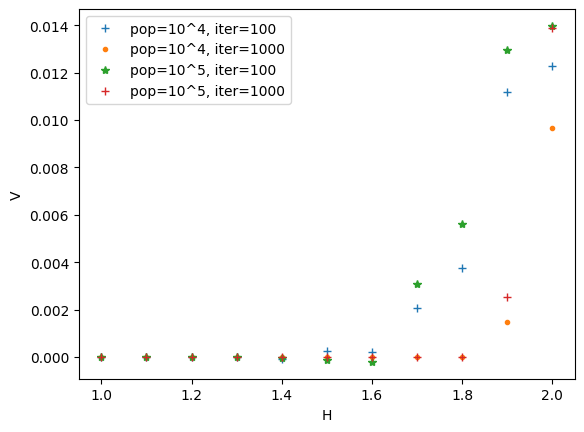

PyObject <matplotlib.legend.Legend object at 0x7f87c804f898>

In [18]:
using PyPlot
xlabel("H")
ylabel("V")
Hs = 1.0:0.1:2.0
plot(Hs,V_r0p2_pop1e4_H1to2, "+", label="pop=10^4, iter=100")
plot(Hs,V_r0p2_pop1e4_H1to2_longiter, ".", label="pop=10^4, iter=1000")
plot(Hs,V_r0p2_pop1e5_H1to2, "*", label="pop=10^5, iter=100")
plot(Hs,V_r0p2_pop1e5_H1to2_longiter, "+", label="pop=10^5, iter=1000")


legend()